In [1]:
import numpy as np
import time
import torch
import random
import pickle
import sys
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim, autograd
from scipy.integrate import odeint

from google.colab import drive
drive.mount("/content/drive")

main_path = "/content/drive/My Drive/Workspace/Fourier_PINN_Stop_Condition/" # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from utils import draw_two_dimension, MultiSubplotDraw

Mounted at /content/drive


In [5]:
class Parameters:
    alpha = 1.00
    beta = 3.00
    gamma = 0.30
    e = 0.333 * 0.30

class TrainArgs:
    iteration = 1000000
    epoch_step = 1000
    test_step = epoch_step * 10
    initial_lr = 0.01
    main_path = "/content/drive/My Drive/Workspace/Fourier_PINN_Stop_Condition/"

    early_stop = True
    early_stop_period = test_step // 2
    early_stop_tolerance = 0.01


class Config:
    def __init__(self):
        self.model_name = "PP_Fourier_Eta"
        self.curve_names = ["U", "V"]
        self.params = Parameters
        self.args = TrainArgs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 1

        self.T = 20
        self.T_unit = 1e-3
        self.T_N = int(self.T / self.T_unit)

        self.prob_dim = 2
        self.y0 = np.asarray([64.73002741, 6.13106793])
        self.t = np.asarray([i * self.T_unit for i in range(self.T_N)])
        self.t_torch = torch.tensor(self.t, dtype=torch.float32).to(self.device)
        # self.x = torch.tensor(np.asarray([[[i * self.T_unit] * self.prob_dim for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)

        omega = 1.4938150574984748

        self.x = torch.tensor(np.asarray([[[i * self.T_unit, np.sin(omega * i * self.T_unit)] for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)
        # print(self.x.shape)
        self.truth = odeint(self.pend, self.y0, self.t)

        self.modes = 64  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.width = 16
        self.fc_map_dim = 128
    
    def pend(self, y, t):
        dydt = np.asarray([
            self.params.alpha * y[0] - self.params.gamma * y[0] * y[1],
            - self.params.beta * y[1] + self.params.e * y[0] * y[1]
        ])
        return dydt


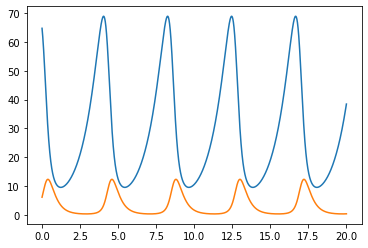

v max at t = 0.385, v = 12.336550871073525
u min at t = 1.231, u = 9.543670574190777
v min at t = 2.898, v = 0.33714006319202156
u max at t = 4.0440000000000005, u = 68.91127378450436
v max at t = 4.591, v = 12.33655082174896
u min at t = 5.437, u = 9.543672950796617
v min at t = 7.104, v = 0.33714019300194054
u max at t = 8.25, u = 68.91128286168596
v max at t = 8.797, v = 12.336549975838837
u min at t = 9.644, u = 9.543674711522227
v min at t = 11.311, v = 0.3371402353482194
u max at t = 12.456, u = 68.91128620473938
v max at t = 13.003, v = 12.336547068561506
u min at t = 13.85, u = 9.543674514344353
v min at t = 15.517, v = 0.3371402678465796
u max at t = 16.662, u = 68.91128347053261
v max at t = 17.209, v = 12.33654192892545
u min at t = 18.056, u = 9.543674634321091
v min at t = 19.723, v = 0.33714036246446977
[4.2059999999999995, 4.2059999999999995, 4.2059999999999995]
[4.206, 4.207, 4.2059999999999995, 4.206000000000001]
[4.206, 4.206, 4.2059999999999995, 4.2059999999999995]
[

In [4]:
config = Config()
tt = config.t
uu = config.truth[:, 0]
vv = config.truth[:, 1]
u_mins = []
u_maxs = []
v_mins = []
v_maxs = []

plt.plot(tt, uu)
plt.plot(tt, vv)
plt.show()
plt.close()

for i in range(len(tt)):
    if 1 <= i <= len(tt) - 2:
        if uu[i - 1] <= uu[i] and  uu[i + 1] <= uu[i]:
            print("u max at t = {}, u = {}".format(tt[i], uu[i]))
            u_maxs.append(tt[i])
        if uu[i - 1] >= uu[i] and  uu[i + 1] >= uu[i]:
            print("u min at t = {}, u = {}".format(tt[i], uu[i]))
            u_mins.append(tt[i])
        if vv[i - 1] <= vv[i] and  vv[i + 1] <= vv[i]:
            print("v max at t = {}, v = {}".format(tt[i], vv[i]))
            v_maxs.append(tt[i])
        if vv[i - 1] >= vv[i] and  vv[i + 1] >= vv[i]:
            print("v min at t = {}, v = {}".format(tt[i], vv[i]))
            v_mins.append(tt[i])
# print(u_maxs)
u_maxs_gap = [u_maxs[i] - u_maxs[i - 1] for i in range(len(u_maxs)) if i > 0]
print(u_maxs_gap)
# print(u_mins)
u_mins_gap = [u_mins[i] - u_mins[i - 1] for i in range(len(u_mins)) if i > 0]
print(u_mins_gap)
# print(v_maxs)
v_maxs_gap = [v_maxs[i] - v_maxs[i - 1] for i in range(len(v_maxs)) if i > 0]
print(v_maxs_gap)
# print(v_mins)
v_mins_gap = [v_mins[i] - v_mins[i - 1] for i in range(len(v_mins)) if i > 0]
print(v_mins_gap)

gaps = u_maxs_gap + u_mins_gap + v_maxs_gap + v_mins_gap
t_cycle = sum(gaps) / len(gaps)
print("t_cycle = {}".format(t_cycle))
omega = 2 * np.pi / t_cycle
print("omega = {}".format(omega))

In [3]:
class SpectralConv1d(nn.Module):
    def __init__(self, config):
        super(SpectralConv1d, self).__init__()
        self.config = config
        self.in_channels = self.config.width
        self.out_channels = self.config.width
        self.scale = 1 / (self.in_channels * self.out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.config.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat).to(self.config.device) 
        out_ft[:, :, :self.config.modes] = self.compl_mul1d(x_ft[:, :, :self.config.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FourierModel(nn.Module):
    def __init__(self, config):
        super(FourierModel, self).__init__()
        self.time_string = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        self.config = config
        self.setup_seed(self.config.seed)
        
        self.fc0 = nn.Linear(1 + 1, self.config.width)  # input channel is 2: (a(x), x)
        # self.fc0 = nn.Linear(self.config.prob_dim, self.config.width)  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.config)
        self.conv1 = SpectralConv1d(self.config)
        self.conv2 = SpectralConv1d(self.config)
        self.conv3 = SpectralConv1d(self.config)
        self.w0 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w1 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w2 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w3 = nn.Conv1d(self.config.width, self.config.width, 1)

        self.fc1 = nn.Linear(self.config.width, self.config.fc_map_dim)
        self.fc2 = nn.Linear(self.config.fc_map_dim, self.config.prob_dim)

        self.criterion = torch.nn.MSELoss().to(self.config.device)  # "sum"

        self.y_tmp = None
        self.epoch_tmp = None
        self.loss_record_tmp = None

        self.figure_save_path_folder = "{0}/saves/figure/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        self.train_save_path_folder = "{0}/saves/train/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        if not os.path.exists(self.figure_save_path_folder):
            os.makedirs(self.figure_save_path_folder)
        if not os.path.exists(self.train_save_path_folder):
            os.makedirs(self.train_save_path_folder)
        self.default_colors = ["red", "blue", "green", "orange", "cyan", "purple", "pink", "indigo", "brown", "grey"]

        print("using {}".format(str(self.config.device)))
        print("iteration = {}".format(self.config.args.iteration))
        print("epoch_step = {}".format(self.config.args.epoch_step))
        print("test_step = {}".format(self.config.args.test_step))
        print("model_name = {}".format(self.config.model_name))
        print("time_string = {}".format(self.time_string))
        self.truth_loss()
    
    def truth_loss(self):
        y_truth = torch.tensor(self.config.truth.reshape([1, self.config.T_N ,self.config.prob_dim])).to(self.config.device)
        tl, tl_list = self.loss(y_truth)
        loss_print_part = " ".join(["Loss_{0:d}:{1:.8f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(tl_list)])
        print("Ground truth has loss: Loss:{0:.8f} {1}".format(tl.item(), loss_print_part))
    
    #  MSE-loss of predicted value against truth
    def real_loss(self, y):
        real_loss = self.criterion(y[0, :, :], torch.tensor(self.config.truth[:, :]).to(self.config.device))
        return real_loss
    
    def early_stop(self):
        if not self.config.args.early_stop or len(self.loss_record_tmp) < 2 * self.config.args.early_stop_period:
            return False
        sum_old = sum(self.loss_record_tmp[- 2 * self.config.args.early_stop_period: - self.config.args.early_stop_period])
        sum_new = sum(self.loss_record_tmp[- self.config.args.early_stop_period:])
        if (sum_new - sum_old) / sum_old < - self.config.args.early_stop_tolerance:
            print("[Early Stop] epoch [{0:d}:{1:d}] -> [{1:d}:{2:d}] reduces {3:.4f} (tolerance = {4:.4f})".format(
                len(self.loss_record_tmp) - 2 * self.config.args.early_stop_period,
                len(self.loss_record_tmp) - self.config.args.early_stop_period,
                len(self.loss_record_tmp),
                (sum_old - sum_new) / sum_old,
                self.config.args.early_stop_tolerance
            ))
            return False
        else:
            print("[Early Stop] epoch [{0:d}:{1:d}] -> [{1:d}:{2:d}] reduces {3:.4f} (tolerance = {4:.4f})".format(
                len(self.loss_record_tmp) - 2 * self.config.args.early_stop_period,
                len(self.loss_record_tmp) - self.config.args.early_stop_period,
                len(self.loss_record_tmp),
                (sum_old - sum_new) / sum_old,
                self.config.args.early_stop_tolerance
            ))
            print("[Early Stop] Early Stop!")
            return True


    def forward(self, x):
        # print("cp1", x.shape)
        x = self.fc0(x)
        # print("cp2", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp3", x.shape)

        x1 = self.conv0(x)
        # print("cp4", x1.shape)
        x2 = self.w0(x)
        # print("cp5", x2.shape)
        x = x1 + x2
        x = F.gelu(x)
        # print("cp6", x.shape)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # print("cp7", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp8", x.shape)
        x = self.fc1(x)
        # print("cp9", x.shape)
        x = F.gelu(x)
        # print("cp10", x.shape)

        x = self.fc2(x)
        # print("cp11", x.shape)

        # print(x.shape)
        return x
    
    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
    
    def ode_gradient(self, x, y):
        u = y[0, :, 0]
        v = y[0, :, 1]
        u_t = torch.gradient(u, spacing=(self.config.t_torch,))[0]
        v_t = torch.gradient(v, spacing=(self.config.t_torch,))[0]
        return u_t - (self.config.params.alpha - self.config.params.gamma * v) * u, v_t - (self.config.params.e * u - self.config.params.beta) * v

    def loss(self, y):
        y0_pred = y[0, 0, :]
        y0_true = torch.tensor(self.config.y0, dtype=torch.float32).to(self.config.device)

        ode_1, ode_2 = self.ode_gradient(self.config.x, y)
        zeros_1D = torch.tensor([0.0] * self.config.T_N).to(self.config.device)

        loss1 = self.criterion(y0_pred, y0_true)
        loss2 = 10 * (self.criterion(ode_1, zeros_1D) + self.criterion(ode_2, zeros_1D))
        loss3 = self.criterion(torch.abs(y[:, :, 0] - 9), y[:, :, 0] - 9) + self.criterion(torch.abs(y[:, :, 1]), y[:, :, 1])
        # loss4 = self.criterion(1 / u_0, pt_all_zeros_3)
        # loss5 = self.criterion(torch.abs(u_0 - v_0), u_0 - v_0)

        loss = loss1 + loss2 + loss3
        loss_list = [loss1, loss2, loss3]
        return loss, loss_list
    

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.args.initial_lr, weight_decay=0)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: 1 / (e / 10000 + 1))
        self.train()

        start_time = time.time()
        start_time_0 = start_time
        loss_record = []
        real_loss_record = []
        time_record = []
        
        for epoch in range(1, self.config.args.iteration + 1):
            optimizer.zero_grad()

            y = self.forward(self.config.x)
            loss, loss_list = self.loss(y)
            loss_record.append(loss.item())
            real_loss = self.real_loss(y)
            real_loss_record.append(real_loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

            now_time = time.time()
            time_record.append(now_time - start_time_0)

            if epoch % self.config.args.epoch_step == 0:
                loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
                print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, self.config.args.iteration, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (self.config.args.iteration - epoch)))
                start_time = now_time

                if epoch % self.config.args.test_step == 0:
                    self.y_tmp = y
                    self.epoch_tmp = epoch
                    self.loss_record_tmp = loss_record
                    self.test_model()
                    # save_path_loss = "{}/{}_{}_loss.npy".format(self.train_save_path_folder, self.config.model_name, self.time_string)
                    # np.save(save_path_loss, np.asarray(loss_record))

                    print("saving training info ...")
                    train_info = {
                        "model_name": self.config.model_name,
                        "seed": self.config.seed,
                        "epoch": self.config.args.iteration,
                        "epoch_stop": self.epoch_tmp,
                        "loss": np.asarray(loss_record),
                        "real_loss": np.asarray(real_loss_record),
                        "time": np.asarray(time_record),
                        "y_predict": y[0, :, :].cpu().detach().numpy(),
                        "y_truth": self.config.truth,
                        "y_shape": self.config.truth.shape,
                        "config": self.config,
                        "time_string": self.time_string,
                    }
                    train_info_path_loss = "{}/{}_{}_info.npy".format(self.train_save_path_folder, self.config.model_name, self.time_string)
                    with open(train_info_path_loss, "wb") as f:
                        pickle.dump(train_info, f)

                    if self.early_stop():
                        print(train_info)
                        break
    
    def test_model(self):
        y_draw = self.y_tmp[0].cpu().detach().numpy().swapaxes(0, 1)
        x_draw = self.config.t
        y_draw_truth = self.config.truth.swapaxes(0, 1)
        save_path = "{}/{}_{}_epoch={}.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        # draw_two_dimension(
        #     y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
        #     x_list=x_draw,
        #     color_list=self.default_colors[: 2 * self.config.prob_dim],
        #     legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
        #     line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
        #     fig_title="{}_{}_epoch={}".format(self.config.model_name, self.time_string, self.epoch_tmp),
        #     fig_size=(8, 6),
        #     show_flag=True,
        #     save_flag=True,
        #     save_path=save_path,
        #     save_dpi=300
        # )
        draw_two_dimension(
            y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
            x_list=x_draw,
            # color_list=self.default_colors[: 2 * self.config.prob_dim],
            # legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
            # line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
            # fig_title="{}_{}_epoch={}".format(self.config.model_name, self.time_string, self.epoch_tmp),
            fig_size=(8, 6),
            # show_flag=True,
            # save_flag=True,
            # save_path=save_path,
            save_dpi=300,
            color_list=["red", "blue", "pink", "cyan"],
            # legend_list=["$U_{pred}$", "$V_{pred}$", "$U_{true}$", "$V_{true}$"],
            # legend_list=["u", "v", "ut", "vt"], 
            line_style_list=["solid", "solid", "dashed", "dashed"],
            # fig_title="PP - 2000000 iterations",
            # fig_size=(8, 6),
            # legend_loc="upper left",
            show_flag=True,
            save_flag=True,
            save_path=save_path,
            fig_x_label=None,
            fig_y_label=None,
            x_ticks_set_flag=True,
            x_ticks=range(0, 21, 5),
            x_label_size=20,
            y_label_size=20,
            number_label_size=20,
        )
        save_path_model = "{}/{}_{}_model.pt".format(self.figure_save_path_folder, self.config.model_name, self.time_string)
        torch.save(self.state_dict(), save_path_model)
        
        """
        color_list=["red", "blue", "pink", "cyan"],
    # legend_list=["$U_{pred}$", "$V_{pred}$", "$U_{true}$", "$V_{true}$"],
    # legend_list=["u", "v", "ut", "vt"], 
    line_style_list=["solid", "solid", "dashed", "dashed"],
    # fig_title="PP - 2000000 iterations",
    fig_size=(8, 6),
    # legend_loc="upper left",
    show_flag=True,
    save_flag=True,
    save_path=main_path + "paper_plots/pp_pinn.png",
    fig_x_label=None,
    fig_y_label=None,
    x_ticks_set_flag=True,
    x_ticks=range(0, 21, 5),
    x_label_size=20,
    y_label_size=20,
    number_label_size=20,
    save_dpi=300,
        """
        print("Figure is saved to {}".format(save_path))
        self.draw_loss_multi(self.loss_record_tmp, [1.0, 0.5, 0.25])
    
    @staticmethod
    def draw_loss_multi(loss_list, last_rate_list):
        m = MultiSubplotDraw(row=1, col=len(last_rate_list), fig_size=(8 * len(last_rate_list), 6), tight_layout_flag=True, show_flag=True, save_flag=False, save_path=None)
        for one_rate in last_rate_list:
            m.add_subplot(
                y_lists=[loss_list[-int(len(loss_list) * one_rate):]],
                x_list=range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1),
                color_list=["blue"],
                line_style_list=["solid"],
                fig_title="Loss - lastest ${}$% - epoch ${}$ to ${}$".format(int(100 * one_rate), len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list)),
                fig_x_label="epoch",
                fig_y_label="loss",
            )
        m.draw()




 


In [4]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.

In [6]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.